In [1]:
!pip install --upgrade -U scikit-learn

     |████████████████████████████████| 22.3MB 49.3MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("L_Group_Data.csv")
df['EXPOSURE'] /= 365.25

In [4]:
df.sort_values(['EXPOSURE', 'CLAIMNO'], ascending=[True, False])

,F1,F3,F4,F5,F8,F9,F10,F11,F12,F13,EXPOSURE,CLAIMNO
42718,P,5,2,2,M1,S2,M2,L2,B,0,0.000219,1
302,F,14,4,2,H2,S0,M3,L2,D,1,0.000219,0
438,F,14,2,2,M2,S2,M1,L4,D,2,0.000219,0
441,F,14,8,2,H2,S1,M3,L3,B,1,0.000219,0
507,F,8,4,2,H1,S1,M1,L3,E,0,0.000219,0
...,...,...,...,...,...,...,...,...,...,...,...,...
20447,F,1,10,2,M1,S2,M1,L2,D,0,13.323149,117
29063,F,1,10,2,M1,S2,M1,L1,B,0,14.125969,76
21544,F,1,14,2,M1,S3,M1,L1,B,0,15.610924,147
23049,F,1,10,2,M1,S2,M1,L2,B,0,18.029925,144


Average FREQUENCY = 10.505646424367717
Standard Deviation of FREQUENCY = 21.591049841986216
Fraction of exposure with zero claims = 22.5%


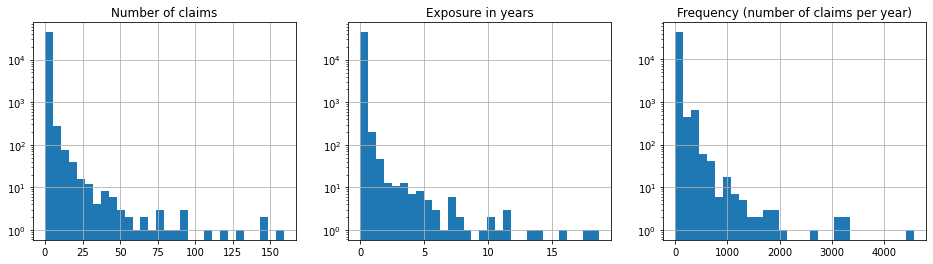

In [5]:
df["FREQUENCY"] = df["CLAIMNO"] / df["EXPOSURE"]

avg = np.average(df["FREQUENCY"], weights=df["EXPOSURE"])
var = np.average((df["FREQUENCY"]-avg)**2, weights=df["EXPOSURE"])

print("Average FREQUENCY = {}"
      .format(avg))
print("Standard Deviation of FREQUENCY = {}"
      .format(np.sqrt(var)))


print("Fraction of exposure with zero claims = {0:.1%}"
      .format(df.loc[df["CLAIMNO"] == 0, "EXPOSURE"].sum() /
              df["EXPOSURE"].sum()))

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 4))
ax0.set_title("Number of claims")
_ = df["CLAIMNO"].hist(bins=30, log=True, ax=ax0)
ax1.set_title("Exposure in years")
_ = df["EXPOSURE"].hist(bins=30, log=True, ax=ax1)
ax2.set_title("Frequency (number of claims per year)")
_ = df["FREQUENCY"].hist(bins=30, log=True, ax=ax2)

In [6]:
df.head()

,F1,F3,F4,F5,F8,F9,F10,F11,F12,F13,EXPOSURE,CLAIMNO,FREQUENCY
0,F,11,4,2,M2,S2,M2,L3,D,0,0.035565,1,28.117783
1,F,5,10,2,M1,S2,M1,L2,B,0,0.805284,10,12.417978
2,P,1,10,2,M1,S5,M0,L1,D,0,0.002738,0,0.000000
3,F,13,10,2,C,S2,M1,L2,B,0,0.044764,1,22.339450
4,F,2,10,2,M1,S1,M1,L1,B,0,0.821410,3,3.652257


In [7]:
for column in df.columns:
  print(column, df[column].unique())

F1 ['F' 'P']
F3 [11  5  1 13  2 10  8 12  3  4 14  7  6  9 15]
F4 [ 4 10  8 20  6  0 14  2]
F5 [2 3 1]
F8 ['M2' 'M1' 'C' 'H1' 'H2']
F9 ['S2' 'S5' 'S1' 'S3' 'S0']
F10 ['M2' 'M1' 'M0' 'M3']
F11 ['L3' 'L2' 'L1' 'L4']
F12 ['D' 'B' 'E']
F13 [0 3 1 2 4 5]
EXPOSURE [0.03556468 0.80528405 0.00273785 ... 0.26921287 0.09995893 0.05793292]
CLAIMNO [  1  10   0   3   2   4  18   5   6  27  14   9   8  20   7  21  16  13
  71  43  11 129  39  17  91  46  12  76  88  24  52  19  40  32  28  15
  30  44  75  22  23  29 117  25  31  35 147  68 144  41  42  61  51  55
 108  26  64  34  95  83 159  48  54  33]
FREQUENCY [28.11778291 12.41797844  0.         ...  9.6194364  26.62172012
 32.75784753]


In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer

linear_model_preprocessor = ColumnTransformer(
    [
        ("passthrough_numeric", "passthrough",
            ["F3", "F4"]),
        ("onehot_categorical", OneHotEncoder(),
            ["F1", "F5", "F8", "F9", "F10", "F11", "F12", "F13"]),
    ],
    remainder="drop",
)

In [9]:
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.33, random_state=0)

dummy = Pipeline([
    ("preprocessor", linear_model_preprocessor),
    ("regressor", DummyRegressor(strategy='mean')),
]).fit(df_train, df_train["FREQUENCY"],
       regressor__sample_weight=df_train["EXPOSURE"])

In [10]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_poisson_deviance


def score_estimator(estimator, df_test):
    """Score an estimator on the test set."""
    y_pred = estimator.predict(df_test)

    print("MSE: %.3f" %
          mean_squared_error(df_test["FREQUENCY"], y_pred,
                             sample_weight=df_test["EXPOSURE"]))
    print("MAE: %.3f" %
          mean_absolute_error(df_test["FREQUENCY"], y_pred,
                              sample_weight=df_test["EXPOSURE"]))

    # Ignore non-positive predictions, as they are invalid for
    # the Poisson deviance.
    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(f"WARNING: Estimator yields invalid, non-positive predictions "
              f" for {n_masked} samples out of {n_samples}. These predictions "
              f"are ignored when computing the Poisson deviance.")

    print("mean Poisson deviance: %.3f" %
          mean_poisson_deviance(df_test["FREQUENCY"][mask],
                                y_pred[mask],
                                sample_weight=df_test["EXPOSURE"][mask]))


print("Constant mean frequency evaluation:")
score_estimator(dummy, df_test)

Constant mean frequency evaluation:
MSE: 470.553
MAE: 7.538
mean Poisson deviance: 14.491


In [11]:
from sklearn.linear_model import Ridge


ridge_glm = Pipeline([
    ("preprocessor", linear_model_preprocessor),
    ("regressor", Ridge(alpha=1e-6)),
]).fit(df_train, df_train["FREQUENCY"],
       regressor__sample_weight=df_train["EXPOSURE"])


In [12]:
print("Ridge evaluation:")
score_estimator(ridge_glm, df_test)

Ridge evaluation:
MSE: 458.999
MAE: 6.732
mean Poisson deviance: 13.530


In [13]:
from sklearn.linear_model import PoissonRegressor

n_samples = df_train.shape[0]

poisson_glm = Pipeline([
    ("preprocessor", linear_model_preprocessor),
    ("regressor", PoissonRegressor(alpha=1e-12, max_iter=300))
])
poisson_glm.fit(df_train, df_train["FREQUENCY"],
                regressor__sample_weight=df_train["EXPOSURE"])

print("PoissonRegressor evaluation:")
score_estimator(poisson_glm, df_test)


PoissonRegressor evaluation:
MSE: 457.215
MAE: 7.027
mean Poisson deviance: 13.408


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


In [15]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder


tree_preprocessor = ColumnTransformer(
    [
        ("categorical", OrdinalEncoder(),
            ["F1", "F5", "F8", "F9", "F10", "F11", "F12", "F13"]),
        ("numeric", "passthrough",
            ["F3", "F4"]),
    ],
    remainder="drop",
)
poisson_gbrt = Pipeline([
    ("preprocessor", tree_preprocessor),
    ("regressor", HistGradientBoostingRegressor(loss="poisson",
                                                max_leaf_nodes=128)),
])
poisson_gbrt.fit(df_train, df_train["FREQUENCY"],
                 regressor__sample_weight=df_train["EXPOSURE"])

print("Poisson Gradient Boosted Trees evaluation:")
score_estimator(poisson_gbrt, df_test)

Poisson Gradient Boosted Trees evaluation:
MSE: 462.415
MAE: 6.966
mean Poisson deviance: 13.614


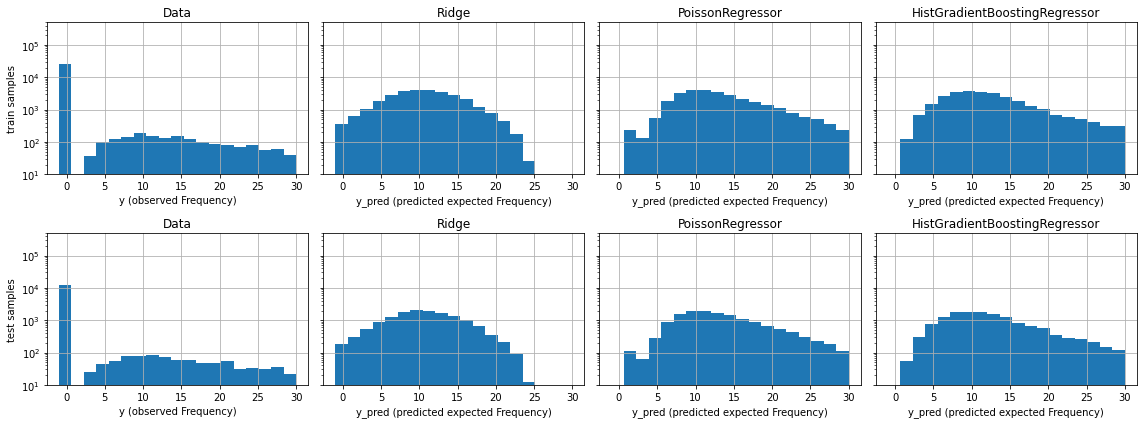

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharey=True)
fig.subplots_adjust(bottom=0.2)
n_bins = 20
for row_idx, label, df in zip(range(2),
                              ["train", "test"],
                              [df_train, df_test]):
    df["FREQUENCY"].hist(bins=np.linspace(-1, 30, n_bins),
                         ax=axes[row_idx, 0])

    axes[row_idx, 0].set_title("Data")
    axes[row_idx, 0].set_yscale('log')
    axes[row_idx, 0].set_xlabel("y (observed Frequency)")
    axes[row_idx, 0].set_ylim([1e1, 5e5])
    axes[row_idx, 0].set_ylabel(label + " samples")

    for idx, model in enumerate([ridge_glm, poisson_glm, poisson_gbrt]):
        y_pred = model.predict(df)

        pd.Series(y_pred).hist(bins=np.linspace(-1, 30, n_bins),
                               ax=axes[row_idx, idx+1])
        axes[row_idx, idx + 1].set(
            title=model[-1].__class__.__name__,
            yscale='log',
            xlabel="y_pred (predicted expected Frequency)"
        )
plt.tight_layout()

Actual number of claims: 5256
Predicted number of claims by Ridge(alpha=1e-06): 4827.0
Predicted number of claims by PoissonRegressor(alpha=1e-12, max_iter=300): 5194.3
Predicted number of claims by HistGradientBoostingRegressor(loss='poisson', max_leaf_nodes=128): 5203.7
Predicted number of claims by DummyRegressor(): 5218.5


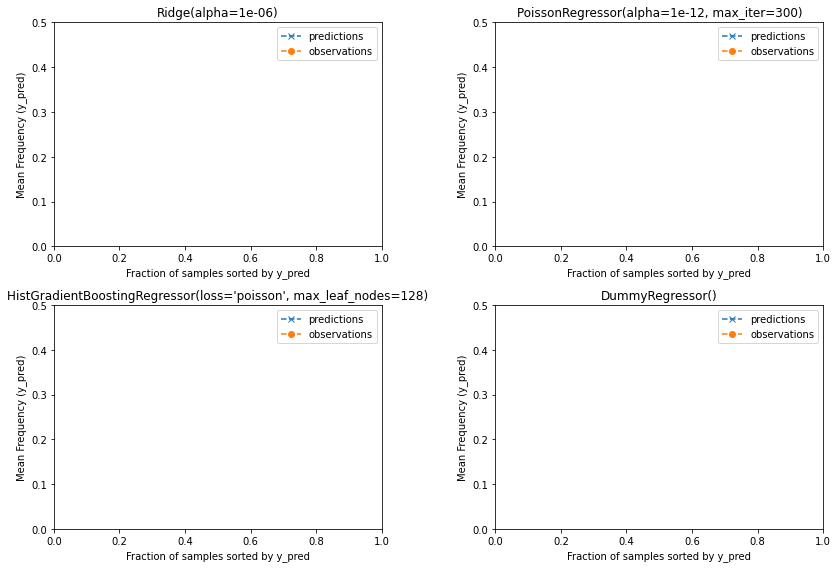

In [17]:
from sklearn.utils import gen_even_slices


def _mean_frequency_by_risk_group(y_true, y_pred, sample_weight=None,
                                  n_bins=100):
    """Compare predictions and observations for bins ordered by y_pred.

    We order the samples by ``y_pred`` and split it in bins.
    In each bin the observed mean is compared with the predicted mean.

    Parameters
    ----------
    y_true: array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred: array-like of shape (n_samples,)
        Estimated target values.
    sample_weight : array-like of shape (n_samples,)
        Sample weights.
    n_bins: int
        Number of bins to use.

    Returns
    -------
    bin_centers: ndarray of shape (n_bins,)
        bin centers
    y_true_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    y_pred_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    """
    idx_sort = np.argsort(y_pred)
    bin_centers = np.arange(0, 1, 1/n_bins) + 0.5/n_bins
    y_pred_bin = np.zeros(n_bins)
    y_true_bin = np.zeros(n_bins)

    for n, sl in enumerate(gen_even_slices(len(y_true), n_bins)):
        weights = sample_weight[idx_sort][sl]
        y_pred_bin[n] = np.average(
            y_pred[idx_sort][sl], weights=weights
        )
        y_true_bin[n] = np.average(
            y_true[idx_sort][sl],
            weights=weights
        )
    return bin_centers, y_true_bin, y_pred_bin


print(f"Actual number of claims: {df_test['CLAIMNO'].sum()}")
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
plt.subplots_adjust(wspace=0.3)

for axi, model in zip(ax.ravel(), [ridge_glm, poisson_glm, poisson_gbrt,
                                   dummy]):
    y_pred = model.predict(df_test)
    y_true = df_test["FREQUENCY"].values
    exposure = df_test["EXPOSURE"].values
    q, y_true_seg, y_pred_seg = _mean_frequency_by_risk_group(
        y_true, y_pred, sample_weight=exposure, n_bins=10)

    # Name of the model after the estimator used in the last step of the
    # pipeline.
    print(f"Predicted number of claims by {model[-1]}: "
          f"{np.sum(y_pred * exposure):.1f}")

    axi.plot(q, y_pred_seg, marker='x', linestyle="--", label="predictions")
    axi.plot(q, y_true_seg, marker='o', linestyle="--", label="observations")
    axi.set_xlim(0, 1.0)
    axi.set_ylim(0, 0.5)
    axi.set(
        title=model[-1],
        xlabel='Fraction of samples sorted by y_pred',
        ylabel='Mean Frequency (y_pred)'
    )
    axi.legend()
plt.tight_layout()

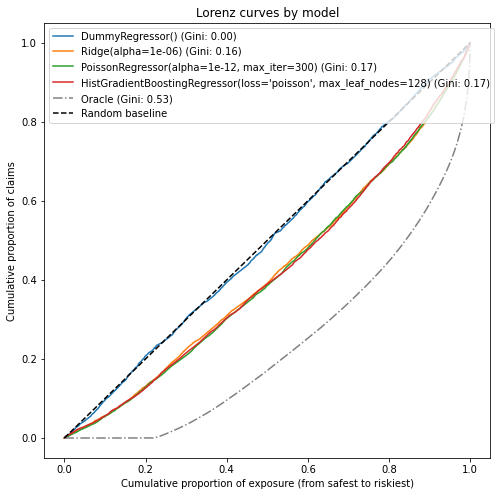

In [18]:
from sklearn.metrics import auc


def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_frequencies = y_true[ranking]
    ranked_exposure = exposure[ranking]
    cumulated_claims = np.cumsum(ranked_frequencies * ranked_exposure)
    cumulated_claims /= cumulated_claims[-1]
    cumulated_exposure = np.cumsum(ranked_exposure)
    cumulated_exposure /= cumulated_exposure[-1]
    return cumulated_exposure, cumulated_claims


fig, ax = plt.subplots(figsize=(8, 8))

for model in [dummy, ridge_glm, poisson_glm, poisson_gbrt]:
    y_pred = model.predict(df_test)
    cum_exposure, cum_claims = lorenz_curve(df_test["FREQUENCY"], y_pred,
                                            df_test["EXPOSURE"])
    gini = 1 - 2 * auc(cum_exposure, cum_claims)
    label = "{} (Gini: {:.2f})".format(model[-1], gini)
    ax.plot(cum_exposure, cum_claims, linestyle="-", label=label)

# Oracle model: y_pred == y_test
cum_exposure, cum_claims = lorenz_curve(df_test["FREQUENCY"],
                                        df_test["FREQUENCY"],
                                        df_test["EXPOSURE"])
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "Oracle (Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-.", color="gray", label=label)

# Random Baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black",
        label="Random baseline")
ax.set(
    title="Lorenz curves by model",
    xlabel='Cumulative proportion of exposure (from safest to riskiest)',
    ylabel='Cumulative proportion of claims'
)
ax.legend(loc="upper left")